<a href="https://colab.research.google.com/github/Mohammed70S/pinFace/blob/main/PinFace1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hereisburak/pins-face-recognition")
print("Path to dataset files:", path)


100%|██████████| 372M/372M [00:05<00:00, 66.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hereisburak/pins-face-recognition/versions/1


Found 14071 images belonging to 105 classes.
Found 3463 images belonging to 105 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 96s 194ms/step - accuracy: 0.0367 - loss: 5.0712 - val_accuracy: 0.1193 - val_loss: 3.6629 - learning_rate: 0.0010
Epoch 2/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 122s 162ms/step - accuracy: 0.1065 - loss: 3.8849 - val_accuracy: 0.1822 - val_loss: 3.3807 - learning_rate: 0.0010
Epoch 3/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 83s 165ms/step - accuracy: 0.1519 - loss: 3.5296 - val_accuracy: 0.2200 - val_loss: 3.1833 - learning_rate: 0.0010
Epoch 4/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 81s 162ms/step - accuracy: 0.1821 - loss: 3.3473 - val_accuracy: 0.2327 - val_loss: 3.0952 - learning_rate: 0.0010
Epoch 5/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 81s 183ms/step - accuracy: 0.2030 - loss: 3.2066 - val_accuracy: 0.2377 - val_loss: 3.0484 - learning_rate: 0.0010
Epoch 6/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 73s 161ms/step - accuracy: 0.2319 - loss: 3.

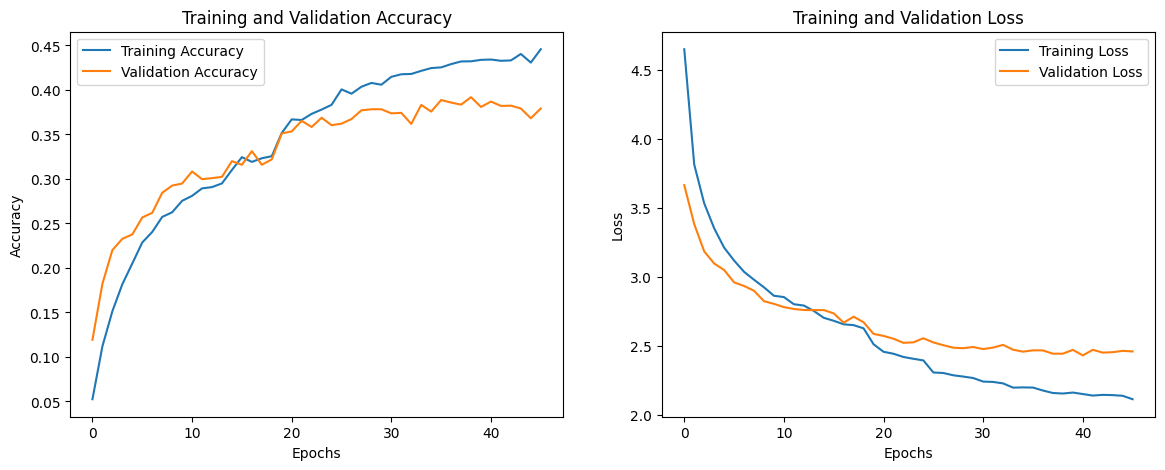

Further tuning may be needed.


In [6]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

# Set constants
IMAGE_SIZE = (100, 100)
BATCH_SIZE = 32
TARGET_ACCURACY = 0.85
DATASET_PATH = "/root/.cache/kagglehub/datasets/hereisburak/pins-face-recognition/versions/1/105_classes_pins_dataset"

# Data Loading and Preprocessing with Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,  # 80-20 split for training and validation
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    shear_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Model Architecture with Transfer Learning (VGG16 base)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
base_model.trainable = False  # Freeze VGG16 layers to retain pre-trained weights

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile Model with Lower Learning Rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Train Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping, lr_scheduler]
)

# Model Evaluation
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Generate Classification Report
true_labels = validation_generator.classes
predictions = np.argmax(model.predict(validation_generator), axis=-1)

# Report with precision, recall, F1-score
print(classification_report(true_labels, predictions, target_names=validation_generator.class_indices.keys()))

# Plot Training and Validation Performance
plt.figure(figsize=(14, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Final Accuracy Check
if val_accuracy >= TARGET_ACCURACY:
    print(f"Target accuracy of {TARGET_ACCURACY*100}% achieved!")
else:
    print("Further tuning may be needed.")
